In [69]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import pandas as pd
import os
import random
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np
from utils import custom_train_test_split, lgbm_predict, post_slack
base_feats = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
         'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum']
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함

## 1. 데이터 로딩
data_dir = '/opt/ml/input/data' # 경로
# train_file_path = os.path.join(data_dir, 'train_data.csv') # 데이터
# test_file_path = os.path.join(data_dir, 'test_data.csv')
after_fe_path = os.path.join(data_dir, 'after_fe_train_test_cumsum.pkl')
df = pd.read_pickle(after_fe_path)

train_df = df[df.kind=='train']
train, valid = custom_train_test_split(train_df, ratio=0.7, seed=13) # 훈련데이터 split
test = df[df.kind=='test'] # 테스트 데이터
train2 = test[test.answerCode!=-1] # 테스트데이터 마지막 제출 2번쨰꺼까지 훈련데이터로 사용
train = pd.concat([train_df,train2]) # 훈련데이터 병합
train.shape, valid.shape, test.shape

x_train = train.drop('answerCode',axis=1)
y_train = train[['answerCode']]

x_valid = valid.drop('answerCode',axis=1)
y_valid = valid[['answerCode']]
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((2525956, 31), (1974, 31), (260114, 31))

((2525956, 30), (2525956, 1), (1974, 30), (1974, 1))

In [28]:
df[:3]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,month,...,time_category,test_mean,test_std,test_sum,tag_mean,tag_std,tag_sum,kind,solvesec_cumsum,solvecumsum_category
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,NaN,0,NaN,3,...,0,0.947683,0.222749,1268,0.955022,0.207410,637,train,0.0,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1.0,1,1.0,3,...,1,0.947683,0.222749,1268,0.913187,0.281603,3040,train,3.0,1
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2.0,2,1.0,3,...,3,0.947683,0.222749,1268,0.913187,0.281603,3040,train,11.0,4


In [3]:
params = {
#     "max_depth": 8,  # 8,
#     "min_data_in_leaf": 1000,
    # "feature_fraction": 0.6,  # 0.8,
#     "bagging_fraction": 0.75,
    # "max_cat_group": 64,
    "objective": "binary",
#     "boosting": "gbdt",  # dart
#     "learning_rate": 0.01,  # 0.01,
    # "bagging_freq": 5,
    "seed": 42,
    # "max_bin": 50,
#     "num_leaves": 80,  # 40,
#     "metric": "auc",
}

model_auc = lgb.LGBMClassifier(
    **params,
    n_estimators=3200,
    silent=-1,
)

model_loss = lgb.LGBMClassifier(
    **params,
    n_estimators=3200,
    silent=-1,
)

## Cumsum 추가 (3601로 나눔)

In [4]:
# 사용할 Feature 설정
FEATS = ['KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum'
        ]

lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

model1 = lgb.train(
    params, 
    lgb_x_train,
    valid_sets=[lgb_x_valid],
    verbose_eval=100,
    num_boost_round=3200,
#     early_stopping_rounds=200,
)

preds = model1.predict(x_valid[FEATS])
acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_valid, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

post_slack("done")
lgbm_predict(test, model1, FEATS, 'LGBM_Baseline_solvetime_Cumsum추가.csv')
# 제출 AUC: 0.7847

[LightGBM] [Info] Number of positive: 1653588, number of negative: 872368
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3360
[LightGBM] [Info] Number of data points in the train set: 2525956, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654638 -> initscore=0.639491
[LightGBM] [Info] Start training from score 0.639491
[100]	valid_0's binary_logloss: 0.583692
[200]	valid_0's binary_logloss: 0.577598
[300]	valid_0's binary_logloss: 0.569466
[400]	valid_0's binary_logloss: 0.563463
[500]	valid_0's binary_logloss: 0.55919
[600]	valid_0's binary_logloss: 0.556276
[700]	valid_0's binary_logloss: 0.554172
[800]	valid_0's binary_logloss: 0.551324
[900]	valid_0's binary_logloss: 0.548944
[1000]	valid_0's binary_logloss: 0.546783
[1100]	valid_0's binary_lo

### NaN값 처리해주기

In [10]:
import missingno as msno

In [13]:
x_train[:1]

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,month,day,...,time_category,test_mean,test_std,test_sum,tag_mean,tag_std,tag_sum,kind,solvesec_cumsum,solvecumsum_category
0,0,A060001001,A060000001,2020-03-24 00:17:11,7224,NaN,0,NaN,3,24,...,0,0.947683,0.222749,1268,0.955022,0.20741,637,train,0.0,0


<AxesSubplot:>

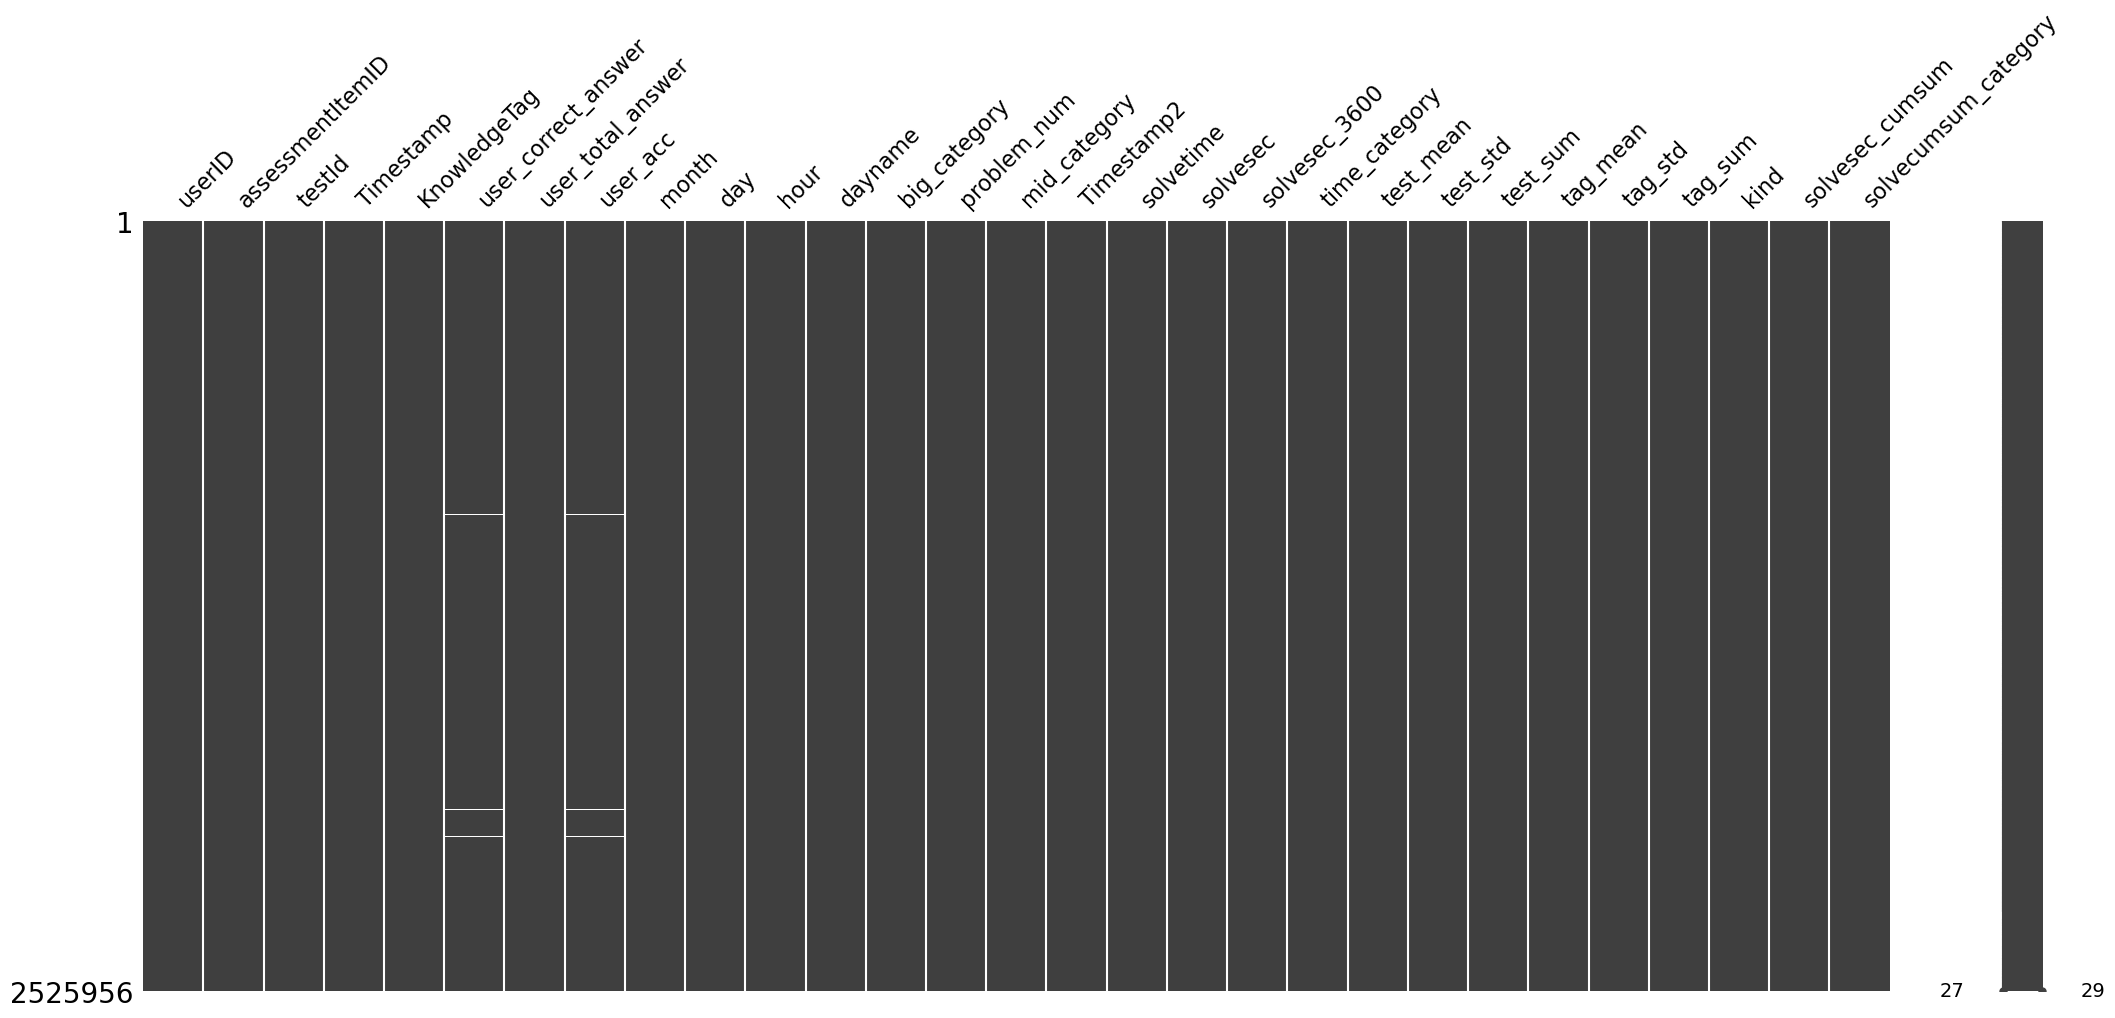

In [12]:
msno.matrix(x_train)

In [16]:
x_train.user_correct_answer = x_train.user_correct_answer.fillna(0)
x_train.user_acc = x_train.user_acc.fillna(0)

<AxesSubplot:>

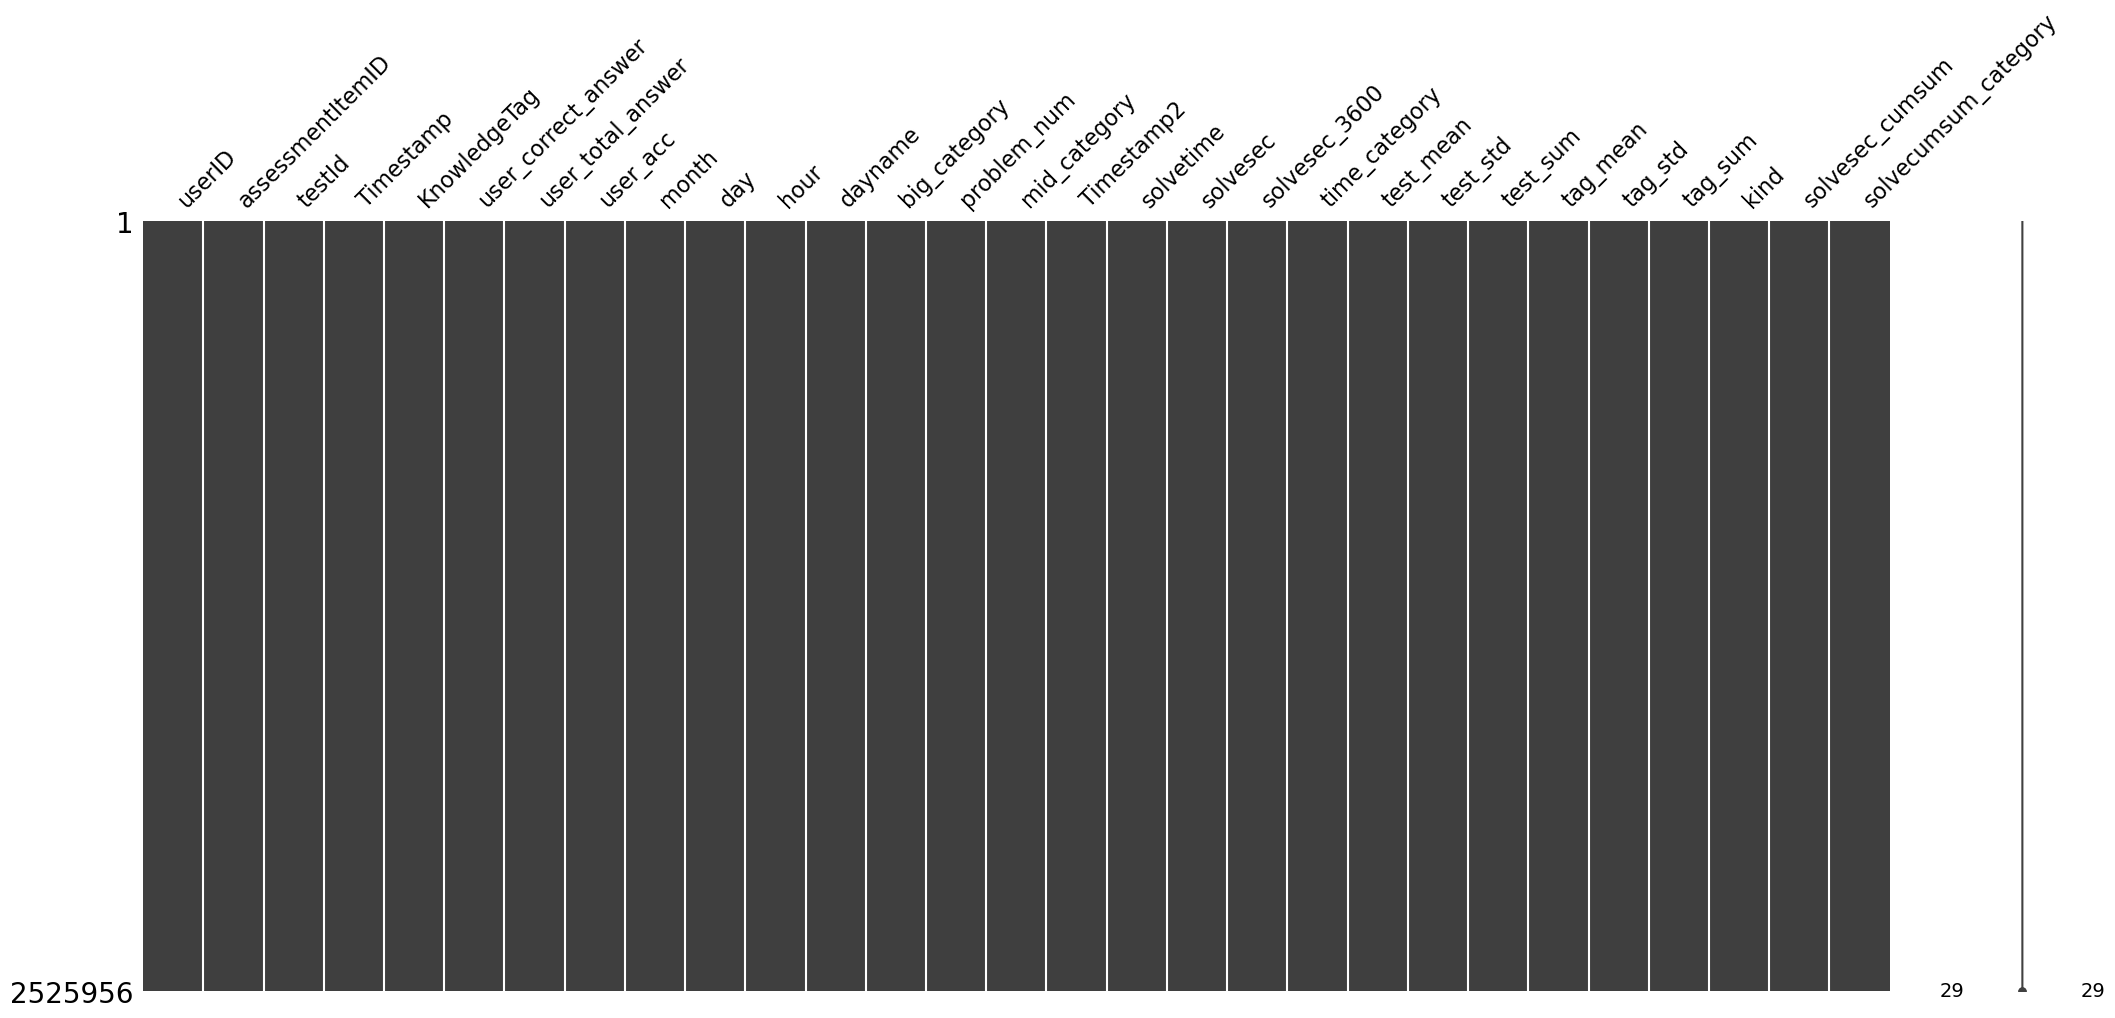

In [18]:
msno.matrix(x_train)

In [19]:
x_valid.user_correct_answer = x_valid.user_correct_answer.fillna(0)
x_valid.user_acc = x_valid.user_acc.fillna(0)

In [21]:
x_valid.shape

(1974, 29)

In [20]:
# 사용할 Feature 설정
FEATS = ['KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
        ]

lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

model1_1 = lgb.train(
    params, 
    lgb_x_train,
    valid_sets=[lgb_x_valid],
    verbose_eval=100,
    num_boost_round=3200,
#     early_stopping_rounds=200,
)

preds = model1_1.predict(x_valid[FEATS])
acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_valid, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

post_slack("done")
lgbm_predict(test, model1_1, FEATS, 'LGBM_Baseline_solvetime_Cumsum추가_카테고리추가_usercorrect_acc_nan처리.csv')
# 제출 AUC: 0.7829

[LightGBM] [Info] Number of positive: 1653588, number of negative: 872368
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3360
[LightGBM] [Info] Number of data points in the train set: 2525956, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654638 -> initscore=0.639491
[LightGBM] [Info] Start training from score 0.639491
[100]	valid_0's binary_logloss: 0.584853
[200]	valid_0's binary_logloss: 0.577546
[300]	valid_0's binary_logloss: 0.571442
[400]	valid_0's binary_logloss: 0.567962
[500]	valid_0's binary_logloss: 0.563974
[600]	valid_0's binary_logloss: 0.560075
[700]	valid_0's binary_logloss: 0.556383
[800]	valid_0's binary_logloss: 0.554245
[900]	valid_0's binary_logloss: 0.550569
[1000]	valid_0's binary_logloss: 0.548632
[1100]	valid_0's binary_l

### x_train에서 NaN 삭제(dropna)

In [33]:
x_train.shape
x_train.dropna().shape

x_valid.shape
x_valid.dropna().shape

(2525956, 29)

(2518514, 29)

(1974, 29)

(1974, 29)

In [34]:
x_train2 = x_train.dropna()

In [40]:
y_train2 = y_train.iloc[x_train2.index]

In [41]:
# 사용할 Feature 설정
FEATS = ['KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum'
        ]

lgb_x_train = lgb.Dataset(x_train2[FEATS], y_train2)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

model1_2 = lgb.train(
    params, 
    lgb_x_train,
    valid_sets=[lgb_x_valid],
    verbose_eval=100,
    num_boost_round=3200,
#     early_stopping_rounds=200,
)

preds = model1_2.predict(x_valid[FEATS])
acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_valid, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

post_slack("done")
lgbm_predict(test, model1_2, FEATS, 'LGBM_Baseline_solvetime_Cumsum추가_train에서Nan삭제.csv')
# 제출 AUC: 

[LightGBM] [Info] Number of positive: 1651267, number of negative: 867247
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3362
[LightGBM] [Info] Number of data points in the train set: 2518514, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655651 -> initscore=0.643974
[LightGBM] [Info] Start training from score 0.643974
[100]	valid_0's binary_logloss: 0.587894
[200]	valid_0's binary_logloss: 0.57879
[300]	valid_0's binary_logloss: 0.571086
[400]	valid_0's binary_logloss: 0.567217
[500]	valid_0's binary_logloss: 0.561538
[600]	valid_0's binary_logloss: 0.557652
[700]	valid_0's binary_logloss: 0.554222
[800]	valid_0's binary_logloss: 0.550872
[900]	valid_0's binary_logloss: 0.5494
[1000]	valid_0's binary_logloss: 0.547781
[1100]	valid_0's binary_logl

### assIdx, testIdx 추가

In [51]:
len(ass2idx),len(test2idx)

(9454, 1537)

In [ ]:
ass2idx = {v:k for k,v in enumerate(sorted(df.assessmentItemID.unique()))}

test2idx = {v:k for k,v in enumerate(sorted(df.testId.unique()))}

In [53]:
x_train3 = x_train.copy()
x_train3['assIdx'] = x_train3.assessmentItemID.map(ass2idx)
x_train3['testIdx'] = x_train3.testId.map(test2idx)

In [56]:
x_valid3 = x_valid.copy()
x_valid3['assIdx'] = x_valid3.assessmentItemID.map(ass2idx)
x_valid3['testIdx'] = x_valid3.testId.map(test2idx)

In [58]:
x_train3[:2]
x_valid3[:2]

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,month,day,...,test_std,test_sum,tag_mean,tag_std,tag_sum,kind,solvesec_cumsum,solvecumsum_category,assIdx,testIdx
0,0,A060001001,A060000001,2020-03-24 00:17:11,7224,NaN,0,NaN,3,24,...,0.222749,1268,0.955022,0.207410,637,train,0.0,0,5354,975
1,0,A060001002,A060000001,2020-03-24 00:17:14,7225,1.0,1,1.0,3,24,...,0.222749,1268,0.913187,0.281603,3040,train,3.0,1,5355,975


,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,month,day,...,test_std,test_sum,tag_mean,tag_std,tag_sum,kind,solvesec_cumsum,solvecumsum_category,assIdx,testIdx
744,0,A080129006,A080000129,2020-12-23 03:40:19,2725,470.0,744,0.631720,12,23,...,0.480143,780,0.301939,0.459258,436,train,286.0,5,8862,1453
1677,1,A090074006,A090000074,2020-11-13 02:47:20,2648,795.0,932,0.853004,11,13,...,0.495401,115,0.440741,0.497398,119,train,328.0,5,9453,1536


In [62]:
test2 = test.copy()
test2['assIdx'] = test2.assessmentItemID.map(ass2idx)
test2['testIdx'] = test2.testId.map(test2idx)

In [64]:
test2[:3]
test.shape

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,month,...,test_std,test_sum,tag_mean,tag_std,tag_sum,kind,solvesec_cumsum,solvecumsum_category,assIdx,testIdx
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,NaN,0,NaN,1,...,0.5004,106,0.587097,0.493952,91,test,0.0,0,4235,804
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,1.0,1,1.0,1,...,0.5004,106,0.587097,0.493952,91,test,26.0,4,4236,804
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,2.0,2,1.0,1,...,0.5004,106,0.588517,0.493284,123,test,120.0,5,4237,804


(260114, 30)

#### assIdx 추가

In [65]:
# 사용할 Feature 설정
FEATS = ['assIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category'
        ]

lgb_x_train = lgb.Dataset(x_train3[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid3[FEATS], y_valid)

model1_31 = lgb.train(
    params, 
    lgb_x_train,
    valid_sets=[lgb_x_valid],
    verbose_eval=100,
    num_boost_round=3200,
#     early_stopping_rounds=200,
)

preds = model1_31.predict(x_valid3[FEATS])
acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_valid, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

post_slack("done")
lgbm_predict(test2, model1_31, FEATS, 'LGBM_Baseline_solvetime_Cumsum추가_assIdx_추가.csv')
# 제출 AUC: 0.7844

[LightGBM] [Info] Number of positive: 1653588, number of negative: 872368
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3624
[LightGBM] [Info] Number of data points in the train set: 2525956, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654638 -> initscore=0.639491
[LightGBM] [Info] Start training from score 0.639491
[100]	valid_0's binary_logloss: 0.583938
[200]	valid_0's binary_logloss: 0.575645
[300]	valid_0's binary_logloss: 0.570356
[400]	valid_0's binary_logloss: 0.564777
[500]	valid_0's binary_logloss: 0.561208
[600]	valid_0's binary_logloss: 0.555872
[700]	valid_0's binary_logloss: 0.552327
[800]	valid_0's binary_logloss: 0.550285
[900]	valid_0's binary_logloss: 0.547807
[1000]	valid_0's binary_logloss: 0.545059
[1100]	valid_0's binary_l

#### testIdx 추가

In [66]:
# 사용할 Feature 설정
FEATS = ['testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category'
        ]

lgb_x_train = lgb.Dataset(x_train3[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid3[FEATS], y_valid)

model1_32 = lgb.train(
    params, 
    lgb_x_train,
    valid_sets=[lgb_x_valid],
    verbose_eval=100,
    num_boost_round=3200,
#     early_stopping_rounds=200,
)

preds = model1_32.predict(x_valid3[FEATS])
acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_valid, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

post_slack("done")
lgbm_predict(test2, model1_32, FEATS, 'LGBM_Baseline_solvetime_Cumsum추가_testIdx_추가.csv')

[LightGBM] [Info] Number of positive: 1653588, number of negative: 872368
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3624
[LightGBM] [Info] Number of data points in the train set: 2525956, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654638 -> initscore=0.639491
[LightGBM] [Info] Start training from score 0.639491
[100]	valid_0's binary_logloss: 0.584324
[200]	valid_0's binary_logloss: 0.576497
[300]	valid_0's binary_logloss: 0.569555
[400]	valid_0's binary_logloss: 0.564757
[500]	valid_0's binary_logloss: 0.560722
[600]	valid_0's binary_logloss: 0.556398
[700]	valid_0's binary_logloss: 0.553725
[800]	valid_0's binary_logloss: 0.551726
[900]	valid_0's binary_logloss: 0.550118
[1000]	valid_0's binary_logloss: 0.54731
[1100]	valid_0's binary_lo

#### assIdx, testIdx 추가

In [68]:
# 사용할 Feature 설정
FEATS = ['assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category'
        ]

lgb_x_train = lgb.Dataset(x_train3[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid3[FEATS], y_valid)

model1_33 = lgb.train(
    params, 
    lgb_x_train,
    valid_sets=[lgb_x_valid],
    verbose_eval=100,
    num_boost_round=3200,
#     early_stopping_rounds=200,
)

preds = model1_33.predict(x_valid3[FEATS])
acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_valid, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

post_slack("done")
lgbm_predict(test2, model1_33, FEATS, 'LGBM_Baseline_solvetime_Cumsum추가_assIdx_testIdx_추가.csv')

[LightGBM] [Info] Number of positive: 1653588, number of negative: 872368
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3879
[LightGBM] [Info] Number of data points in the train set: 2525956, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654638 -> initscore=0.639491
[LightGBM] [Info] Start training from score 0.639491
[100]	valid_0's binary_logloss: 0.58598
[200]	valid_0's binary_logloss: 0.577013
[300]	valid_0's binary_logloss: 0.571151
[400]	valid_0's binary_logloss: 0.566009
[500]	valid_0's binary_logloss: 0.562115
[600]	valid_0's binary_logloss: 0.559377
[700]	valid_0's binary_logloss: 0.555281
[800]	valid_0's binary_logloss: 0.550862
[900]	valid_0's binary_logloss: 0.548275
[1000]	valid_0's binary_logloss: 0.545749
[1100]	valid_0's binary_lo

## Cumsum및 카테고리 추가

In [5]:
# 사용할 Feature 설정
FEATS = ['KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category'
        ]

lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

model2 = lgb.train(
    params, 
    lgb_x_train,
    valid_sets=[lgb_x_valid],
    verbose_eval=100,
    num_boost_round=3200,
#     early_stopping_rounds=200,
)

preds = model2.predict(x_valid[FEATS])
acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_valid, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

post_slack("done")
lgbm_predict(test, model2, FEATS, 'LGBM_Baseline_solvetime_Cumsum추가_카테고리추가_usercorrect_acc_nan처리.csv')

[LightGBM] [Info] Number of positive: 1653588, number of negative: 872368
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3369
[LightGBM] [Info] Number of data points in the train set: 2525956, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654638 -> initscore=0.639491
[LightGBM] [Info] Start training from score 0.639491
[100]	valid_0's binary_logloss: 0.583692
[200]	valid_0's binary_logloss: 0.577598
[300]	valid_0's binary_logloss: 0.571147
[400]	valid_0's binary_logloss: 0.565527
[500]	valid_0's binary_logloss: 0.56144
[600]	valid_0's binary_logloss: 0.559251
[700]	valid_0's binary_logloss: 0.554696
[800]	valid_0's binary_logloss: 0.552521
[900]	valid_0's binary_logloss: 0.549299
[1000]	valid_0's binary_logloss: 0.547183
[1100]	valid_0's binary_lo

In [ ]:
lgbm_predict(test, model, FEATS, 'test.csv')

## Cumsum추가 (3600으로 나눔)

In [70]:
x_train

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,month,day,...,test_mean,test_std,test_sum,tag_mean,tag_std,tag_sum,kind,solvesec_cumsum,solvecumsum_category,solvesec_cumsum2
0,0,A060001001,A060000001,2020-03-24 00:17:11,7224,NaN,0,NaN,3,24,...,0.947683,0.222749,1268,0.955022,0.207410,637,train,0.0,0,0.0
1,0,A060001002,A060000001,2020-03-24 00:17:14,7225,1.0,1,1.0,3,24,...,0.947683,0.222749,1268,0.913187,0.281603,3040,train,3.0,1,3.0
2,0,A060001003,A060000001,2020-03-24 00:17:22,7225,2.0,2,1.0,3,24,...,0.947683,0.222749,1268,0.913187,0.281603,3040,train,11.0,4,11.0


In [71]:
# 사용할 Feature 설정
FEATS = ['KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum2'
        ]

lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

model3 = lgb.train(
    params, 
    lgb_x_train,
    valid_sets=[lgb_x_valid],
    verbose_eval=100,
    num_boost_round=3200,
#     early_stopping_rounds=200,
)

preds = model3.predict(x_valid[FEATS])
acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_valid, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

post_slack("done")
lgbm_predict(test, model3, FEATS, 'LGBM_Baseline_solvetime_Cumsum추가_3600나누기.csv')
# 제출 AUC: 0.7847(기존 1번) →

[LightGBM] [Info] Number of positive: 1653588, number of negative: 872368
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3360
[LightGBM] [Info] Number of data points in the train set: 2525956, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654638 -> initscore=0.639491
[LightGBM] [Info] Start training from score 0.639491
[100]	valid_0's binary_logloss: 0.585607
[200]	valid_0's binary_logloss: 0.576222
[300]	valid_0's binary_logloss: 0.5699
[400]	valid_0's binary_logloss: 0.565599
[500]	valid_0's binary_logloss: 0.561664
[600]	valid_0's binary_logloss: 0.558705
[700]	valid_0's binary_logloss: 0.554077
[800]	valid_0's binary_logloss: 0.551868
[900]	valid_0's binary_logloss: 0.549103
[1000]	valid_0's binary_logloss: 0.547129
[1100]	valid_0's binary_log